<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/Frecuencia%20incripciones/ModeloAutoregresivoPrediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción con AR

In [81]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

# carga de archivo
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Frecuencia%20inscripciones/data/conversionesPE.csv", index_col=0)


## Transformación y formateo de datos

In [82]:
# Transformacion de datos para analisis temporal
df = raw_csv_data.copy()
df=df[df.FuenteIngreso == "UB"]
df['Fecha'] = pd.to_datetime(raw_csv_data.FechaConsultora, dayfirst = True)
df['inscripciones'] = df.cantidad
del df['FuenteIngreso']
del df['Pais']
del df['FechaConsultora']
del df['cantidad']
# se agrupa y se reindexa el dataframe
df = df.groupby(['Fecha']).sum().reset_index()
df.set_index('Fecha', inplace=True, verify_integrity=True)
# establecer frecuencia
#df.sort_index().asfreq(freq='d')
df.index = pd.DatetimeIndex(df.index).to_period('d')
# cambiar frecuencia a meses
#df.index.freq = 'MS'
df.head()
dfAR = df.copy()

## Gráfico de la serie

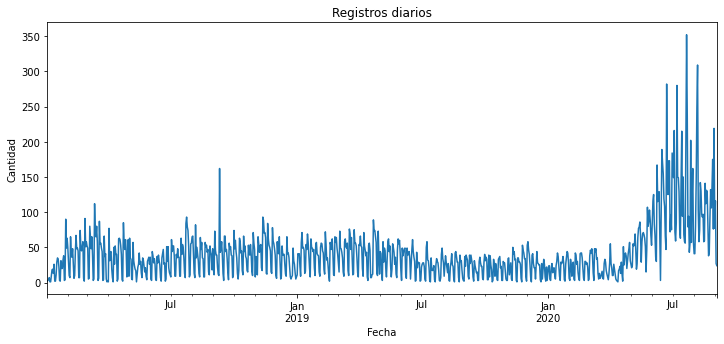

In [83]:
title='Registros diarios'
ylabel='Cantidad'

ax = dfAR['inscripciones'].plot(figsize=(12,5),title=title);
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);

## Datos de entrenamiento y prueba

In [84]:
countRegistros = len(dfAR)
ratioSplit = 0.8

train = dfAR.iloc[:int(countRegistros*ratioSplit)]
test = dfAR.iloc[int(countRegistros*(ratioSplit)):]

## Modelo AR(1)

In [97]:
# ignorar warnings
import warnings
warnings.filterwarnings("ignore")

model = AR(train['inscripciones'])
#maxlag = numero de retraso maximo
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'AIC: {AR1fit.aic}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
AIC: 6.032270949963181
Coefficients:
const               20.313633
L1.inscripciones     0.359258
dtype: float64


In [86]:
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')
predictions1

2020-02-15    27.858056
2020-02-16    30.321869
2020-02-17    31.207014
2020-02-18    31.525010
2020-02-19    31.639253
                ...    
2020-08-22    31.703307
2020-08-23    31.703307
2020-08-24    31.703307
2020-08-25    31.703307
2020-08-26    31.703307
Freq: D, Name: AR(1) Predictions, Length: 194, dtype: float64

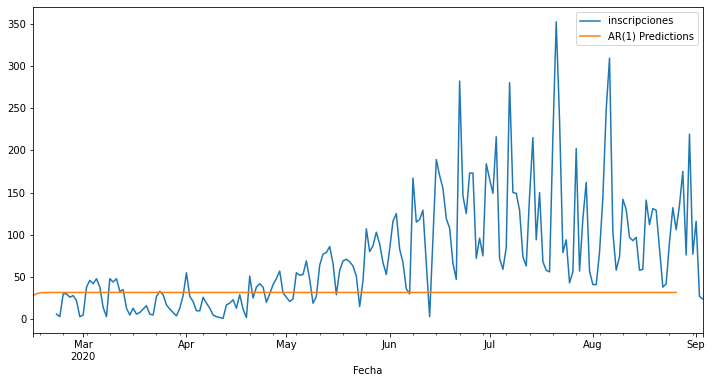

In [87]:
# Comparando predicciones con valores reales
#for i in range(len(predictions1)):
#    print(f"predicted={predictions1[i]:<11.10}, expected={test['inscripciones'][i]}")


test['inscripciones'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

## Modelo AR(2)

In [96]:
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'AIC: {AR2fit.aic}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
AIC: 6.010348167787898
Coefficients:
const               23.491942
L1.inscripciones     0.414917
L2.inscripciones    -0.155494
dtype: float64


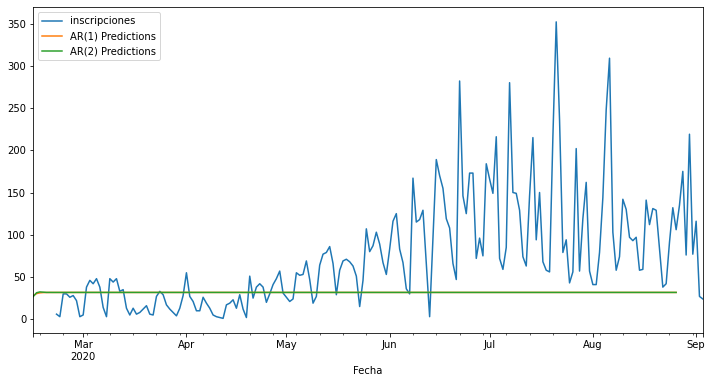

In [89]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

test['inscripciones'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## Modelo AR(p) donde statsmodels elige p

In [94]:
ARfit = model.fit(ic='bic')
# bic criterio de seleccion de retornos
#ARfit = model.fit(ic='bic',method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'AIC: {ARfit.aic}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 15
AIC: 5.217248772266669
Coefficients:
const                6.403776
L1.inscripciones     0.285267
L2.inscripciones     0.023924
L3.inscripciones     0.070911
L4.inscripciones    -0.017192
L5.inscripciones    -0.060005
L6.inscripciones     0.046798
L7.inscripciones     0.512274
L8.inscripciones    -0.104121
L9.inscripciones    -0.055911
L10.inscripciones   -0.053233
L11.inscripciones   -0.027421
L12.inscripciones    0.021985
L13.inscripciones    0.033927
L14.inscripciones    0.249258
L15.inscripciones   -0.123465
dtype: float64


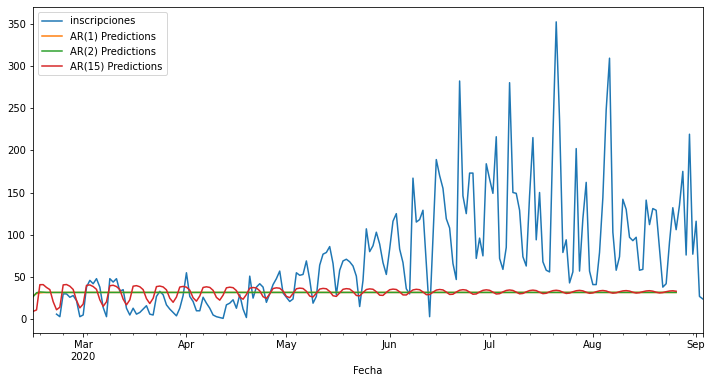

In [91]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(15) Predictions'

predictions15 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)
test['inscripciones'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions15.plot(legend=True,figsize=(12,6));

## Evaluación del modelo

In [92]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(15)']
preds = [predictions1, predictions2, predictions15]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['inscripciones'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 5962.178241
AR(2) Error: 5960.735978
AR(15) Error: 5785.972244


In [101]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 6.0323
AR(2) AIC: 6.0103
AR(15) AIC: 5.2172


La idea es disminuir el AIC con cada modelo

## Predicciones

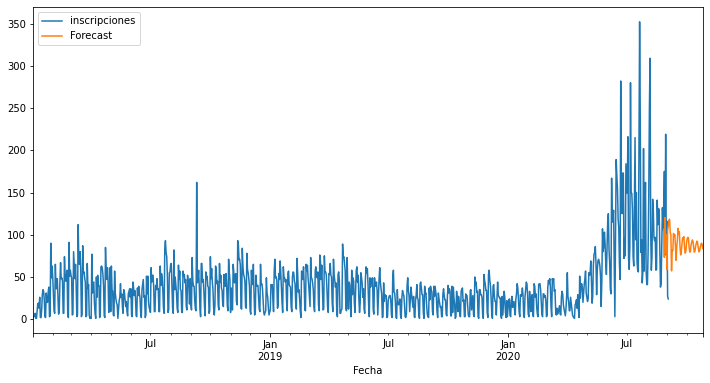

In [105]:
model = AR(dfAR['inscripciones'])

# Next, fit the model
ARfit = model.fit(maxlag=15,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(dfAR), end=len(dfAR)+60, dynamic=False).rename('Forecast')

# Plot the results
df['inscripciones'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));